In [1]:
import numpy as np
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

# Load data
poi_dataset = pd.read_csv('POIdata_cityB.csv')
category_labels = pd.read_csv('POI_datacategories.csv', header=None)

In [2]:
# unique basket for each grid
poi_dataset['unique_grid_id'] = poi_dataset['x'].astype(str) + "," + poi_dataset['y'].astype(str)
grid_category_bundles = poi_dataset.groupby('unique_grid_id')['category'].apply(set)


/Users/rajeshkumar/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
# onehot encoding
total_categories = len(category_labels)
one_hot_encoded_data = [
    [1 if category in bundle else 0 for category in range(1, total_categories + 1)]
    for bundle in grid_category_bundles
]

one_hot_encoded_df = pd.DataFrame(one_hot_encoded_data, columns=category_labels[0])

grid_category_bundle_df = grid_category_bundles.reset_index()
grid_category_bundle_df.columns = ['unique_grid_id', 'category_bundle']
final_poi_df = grid_category_bundle_df.join(one_hot_encoded_df).drop(columns=['category_bundle']).set_index('unique_grid_id')

/Users/rajeshkumar/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
# Find frequent itemsets
frequent_itemsets_poi = apriori(final_poi_df, min_support=0.1, use_colnames=True)

# association rule created
poi_association_rules = association_rules(frequent_itemsets_poi, metric="lift", min_threshold=1, num_itemsets=len(grid_category_bundles))
poi_association_rules = poi_association_rules.sort_values(by=["confidence", "lift"], ascending=[False, False])

# support verification column
frequent_itemsets_poi['verified_support'] = frequent_itemsets_poi['itemsets'].apply(
    lambda itemset: (one_hot_encoded_df[list(itemset)].all(axis=1).sum()) / len(one_hot_encoded_df)
)
frequent_itemsets_poi = frequent_itemsets_poi.sort_values("support", ascending=False).reset_index(drop=True)

/Users/rajeshkumar/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/rajeshkumar/opt/anaconda3/lib/python3.8/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [5]:
# rule processing based on antecedents, consequents and lift
poi_rules_summary = poi_association_rules[['antecedents', 'consequents', 'lift']].copy()
poi_rules_summary['association_rule'] = poi_rules_summary['antecedents'].apply(lambda x: ', '.join(list(x))) + " to " + poi_rules_summary['consequents'].apply(lambda x: ', '.join(list(x)))
poi_rules_summary = poi_rules_summary[['association_rule', 'lift']].sort_values(by='lift', ascending=False).reset_index(drop=True)

# Display the final rules summary
print(poi_rules_summary.head())


                                   association_rule      lift
0                            Hair Salon to Laundry   3.490690
1                            Laundry  to Hair Salon  3.490690
2                         Hair Salon to Real Estate  3.380272
3                         Real Estate to Hair Salon  3.380272
4  Hair Salon to Transit Station, Building Material  3.261651


/Users/rajeshkumar/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/rajeshkumar/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/rajeshkumar/opt/anaconda3/lib/python3.8/site-packages/matplotlib/__init__.py:169: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/Users/rajeshkumar/opt/anaconda3/lib/python3.8/site-packages/setuptools/_distutils/version.py:337: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/rajeshkumar/opt/anaconda3/lib/python3.8/site-packages/matplotlib/__init__.py:169: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version

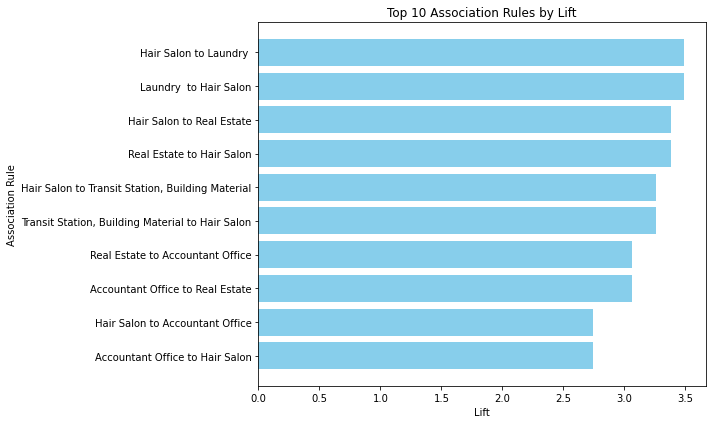

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(poi_rules_summary['association_rule'][:10], poi_rules_summary['lift'][:10], color='skyblue')
plt.xlabel('Lift')
plt.ylabel('Association Rule')
plt.title('Top 10 Association Rules by Lift')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest lift at the top
plt.tight_layout()
plt.show()


/Users/rajeshkumar/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


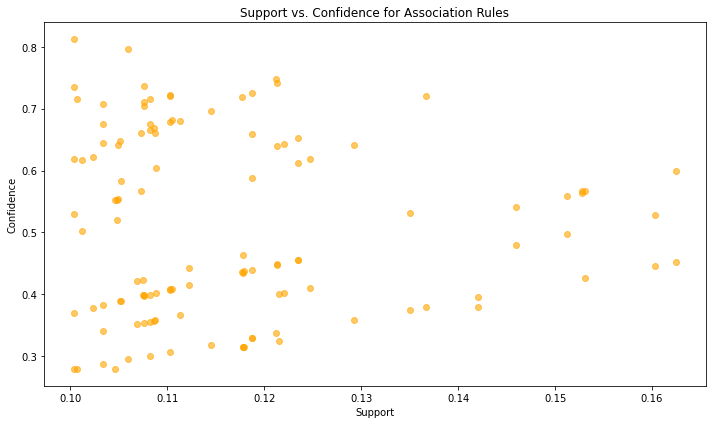

In [7]:
plt.figure(figsize=(10, 6))
plt.scatter(poi_association_rules['support'], poi_association_rules['confidence'], alpha=0.6, color='orange')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Support vs. Confidence for Association Rules')
plt.tight_layout()
plt.show()


/Users/rajeshkumar/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


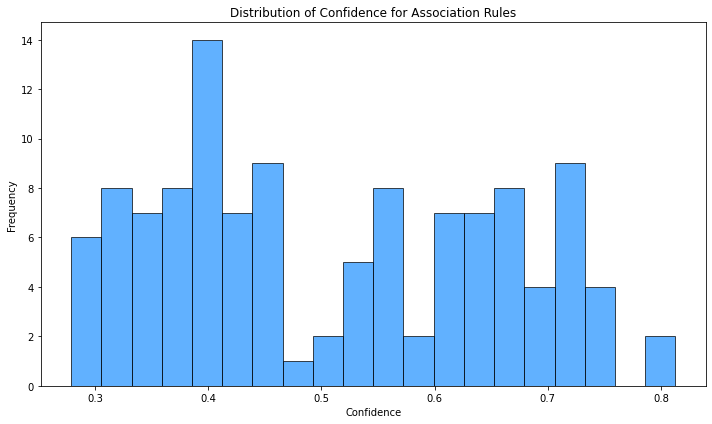

In [8]:
plt.figure(figsize=(10, 6))
plt.hist(poi_association_rules['confidence'], bins=20, color='dodgerblue', edgecolor='black', alpha=0.7)
plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.title('Distribution of Confidence for Association Rules')
plt.tight_layout()
plt.show()